## Linear Discriminant Analysis

### Connect to data sources and import libraries for modeling




In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 83.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import sqlite3
import csv

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from dmba import classificationSummary
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import datetime as dt
from sklearn.metrics import accuracy_score, r2_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE

%matplotlib inline

# Turn off warnings for ease of viewing
import warnings
warnings.filterwarnings("ignore")

# Set option to see all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

no display found. Using non-interactive Agg backend


### Connect to SQL database and bring in the transformed_data table

In [4]:
# Connect to the database
conn = sqlite3.connect('/content/drive/My Drive/MS-ADS Capstone Project/data/hr_case_study.db')

##### Query general_data table ##### 
# Create cursor object and query table
cursor = conn.cursor()
cursor.execute('SELECT * FROM transformed_data AS d')

# Identify the column names for dataframe
col_names = [desc[0] for desc in cursor.description]

# Fetch all rows from the query and store in dataframe
rows = cursor.fetchall()
transformed_sql= pd.DataFrame(rows, columns = col_names)

# Close the cursor and connection objects
cursor.close()
conn.close()

In [5]:
transformed_sql.head()

,index,Unnamed: 0,Education,EmployeeID,JobLevel,NumCompaniesWorked,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,time_id,mean_time,median_time,max_time,num_times_over_9hours,num_times_over_11hours,%_under_8,%_over_9,%_over_11,clipped_TrainingTimesLastYear,clipped_NumCompaniesWorked,log_Age,log_StockOptionLevel,log_YearsSinceLastPromotion,log_TotalWorkingYears,log_YearsAtCompany,log_MonthlyIncome,log_PercentSalaryHike,log_DistanceFromHome,log_clipped_YearsWithCurrentManager,log_clipped_num_times_less_8hours,log_total_days,log_num_times_over_9hours,log_num_times_over_11hours,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Attrition_Yes,Gender_Male,log_AgeBeganWorking,log_WorkingDaysPerYear
0,0,0,0.25,1,1,1.0,0.666667,0.0,0.666667,1.000000,0.333333,1,0 days 07:22:26.896551724,0 days 07:23:00,0 days 07:57:00,0,0,1.0,0.0,0.0,1.00,0.125,0.863147,0.000000,0.00,0.186652,0.186652,0.858755,0.000000,0.462607,0.000000,0.992462,0.847162,0.0,0.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.858668,0.926953
1,1,1,0.00,2,1,0.0,0.333333,1.0,0.666667,0.333333,1.000000,2,0 days 07:43:03.813559322,0 days 07:43:00,0 days 08:34:00,0,0,1.0,0.0,0.0,0.50,0.000,0.446915,0.301030,0.25,0.482489,0.482489,0.476600,0.896477,0.629511,0.671188,0.959652,0.791635,0.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.305588,0.626674
2,2,2,0.75,3,4,1.0,0.666667,0.0,0.333333,0.333333,0.000000,3,0 days 07:00:48.595041322,0 days 06:59:00,0 days 07:59:00,0,0,1.0,0.0,0.0,0.25,0.125,0.473296,0.602060,0.00,0.482489,0.482489,0.988573,0.372072,0.811368,0.578130,1.000000,0.859920,0.0,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0.337215,0.663684
3,3,3,1.00,4,3,3.0,0.333333,0.0,1.000000,1.000000,0.666667,4,0 days 07:11:36.510638298,0 days 07:11:00,0 days 07:53:00,0,0,1.0,0.0,0.0,1.00,0.375,0.616513,0.602060,0.75,0.591674,0.591674,0.706394,0.000000,0.149726,0.747222,0.994756,0.851046,0.0,0.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0.425729,0.581211
4,4,4,0.00,5,1,4.0,0.666667,0.0,1.000000,0.000000,0.666667,5,0 days 08:00:22.530612245,0 days 07:58:00,0 days 08:50:00,0,0,1.0,0.0,0.0,0.25,0.500,0.473296,0.477121,0.00,0.524000,0.524000,0.281920,0.103523,0.629511,0.671188,0.884149,0.663853,0.0,0.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.305588,0.528216


In [6]:
# Columns to keep and create the final base analytics table
cols_to_keep = ['Attrition_Yes','Education','JobLevel','clipped_NumCompaniesWorked','JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                'JobSatisfaction','WorkLifeBalance','%_over_11','clipped_TrainingTimesLastYear','log_Age','log_StockOptionLevel','log_YearsSinceLastPromotion',
                'log_TotalWorkingYears','log_YearsAtCompany','log_MonthlyIncome','log_PercentSalaryHike','log_DistanceFromHome','log_clipped_YearsWithCurrentManager',
                'BusinessTravel_Travel_Frequently','Department_Research & Development','Department_Sales','JobRole_Manager','JobRole_Sales Representative',
                'EducationField_Technical Degree']

# Assign the columns to keep to the model_df variable
model_df = transformed_sql[cols_to_keep]
model_df.head()

,Attrition_Yes,Education,JobLevel,clipped_NumCompaniesWorked,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,%_over_11,clipped_TrainingTimesLastYear,log_Age,log_StockOptionLevel,log_YearsSinceLastPromotion,log_TotalWorkingYears,log_YearsAtCompany,log_MonthlyIncome,log_PercentSalaryHike,log_DistanceFromHome,log_clipped_YearsWithCurrentManager,BusinessTravel_Travel_Frequently,Department_Research & Development,Department_Sales,JobRole_Manager,JobRole_Sales Representative,EducationField_Technical Degree
0,0,0.25,1,0.125,0.666667,0.0,0.666667,1.000000,0.333333,0.0,1.00,0.863147,0.000000,0.00,0.186652,0.186652,0.858755,0.000000,0.462607,0.000000,0,0,1,0,0,0
1,1,0.00,1,0.000,0.333333,1.0,0.666667,0.333333,1.000000,0.0,0.50,0.446915,0.301030,0.25,0.482489,0.482489,0.476600,0.896477,0.629511,0.671188,1,1,0,0,0,0
2,0,0.75,4,0.125,0.666667,0.0,0.333333,0.333333,0.000000,0.0,0.25,0.473296,0.602060,0.00,0.482489,0.482489,0.988573,0.372072,0.811368,0.578130,1,1,0,0,0,0
3,0,1.00,3,0.375,0.333333,0.0,1.000000,1.000000,0.666667,0.0,1.00,0.616513,0.602060,0.75,0.591674,0.591674,0.706394,0.000000,0.149726,0.747222,0,1,0,0,0,0
4,0,0.00,1,0.500,0.666667,0.0,1.000000,0.000000,0.666667,0.0,0.25,0.473296,0.477121,0.00,0.524000,0.524000,0.281920,0.103523,0.629511,0.671188,0,1,0,0,0,0


### Create SGD Classifier

#### Test Train Split Test Method

In [15]:
# Assign the independent and dependent variables
y = model_df['Attrition_Yes']
X = model_df.drop(columns = ['Attrition_Yes'])

# partitioning data into 90% train and 10% test, and then will further split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 12345)

# using 80 / 20 split for train and validation set
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, random_state = 12345)

In [16]:
# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train) # X_smt and y_smt will be used in modeling if concerns around balanced data

y_train_smt.value_counts()

0    2945
1    2945
Name: Attrition_Yes, dtype: int64

In [17]:
# Validate size of train and test data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3528, 25)
(3528,)
(882, 25)
(882,)


In [10]:
# Define function to create scikit-learn classification model standard output
def skl_class_model(train_x=None,
                    train_y=None,
                    val_x=None,
                    val_y=None,
                    skl_model=None,
                    grid=None,
                    cv=5):
  '''takes a scikit-learn classifier, train X/Y, val XY, and grid as input;
  displays class eval metrics for training & val; returns the best fit model'''    
  start_time = dt.datetime.today()
  print('+++++++++++++++++++++++++++++++++++++++++++++++++')
  if grid == None:
      model_fit = skl_model.fit(train_x, train_y)
  else: 
      model_gridcv_fit = GridSearchCV(skl_model,
                                      grid,
                                      cv=cv).fit(train_x, train_y)
      model_fit = model_gridcv_fit.best_estimator_
      print(f'Best CV grid parameters for {skl_model}: {model_gridcv_fit.best_params_}')
  print('Training set')
  classificationSummary(train_y,
                        model_fit.predict(train_x))
  print(f'\nAdditional Eval Measures for {skl_model}:')
  print(f'Recall = {recall_score(train_y, model_fit.predict(train_x))}')
  print(f'Precision = {precision_score(train_y, model_fit.predict(train_x))}')
  print(f'F1 = {f1_score(train_y, model_fit.predict(train_x))}')

  print('\n_________________________________________________')
  print('Val/Test set')
  classificationSummary(val_y,
                        model_fit.predict(val_x))
  print(f'\nAdditional Eval Measures for {skl_model}:')
  print(f'Recall = {recall_score(val_y, model_fit.predict(val_x))}')
  print(f'Precision = {precision_score(val_y, model_fit.predict(val_x))}')
  print(f'F1 = {f1_score(val_y, model_fit.predict(val_x))}')

  end_time = dt.datetime.today()
  time_elapsed = end_time - start_time
  print(f'\nStart Time = {start_time}')
  print(f'End Time = {end_time}')
  print(f'Script Time = {time_elapsed}')
  return model_fit

In [18]:
lda_mod = LinearDiscriminantAnalysis()

lda_mod_grd = {'solver': ['svd', 'lsqr', 'eigen'],
                  'shrinkage': [.001, .01, .05, .1, .5, 1, 'auto', None],
                  'store_covariance': [True, False]}

lda_mod_fit = skl_class_model(train_x = X_train,
                                 train_y = y_train,
                                 val_x=X_test,
                                 val_y=y_test, 
                                 skl_model=lda_mod,
                                 grid=lda_mod_grd,
                                 cv=5)

+++++++++++++++++++++++++++++++++++++++++++++++++
Best CV grid parameters for LinearDiscriminantAnalysis(): {'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True}
Training set
Confusion Matrix (Accuracy 0.8523)

       Prediction
Actual    0    1
     0 2896   49
     1  472  111

Additional Eval Measures for LinearDiscriminantAnalysis():
Recall = 0.19039451114922812
Precision = 0.69375
F1 = 0.29878869448183043

_________________________________________________
Val/Test set
Confusion Matrix (Accuracy 0.8662)

       Prediction
Actual   0   1
     0 743  11
     1 107  21

Additional Eval Measures for LinearDiscriminantAnalysis():
Recall = 0.1640625
Precision = 0.65625
F1 = 0.2625

Start Time = 2023-04-01 16:33:53.848761
End Time = 2023-04-01 16:34:02.450200
Script Time = 0:00:08.601439


In [19]:
# Fit the best model from the LDA grid search with optimal parameters
lda_final = LinearDiscriminantAnalysis(solver ='lsqr',shrinkage=0.05, store_covariance = True).fit(X_train, y_train)

In [20]:
# Predict the test values and probabilities
lda_test = lda_final.predict(X_test)
lda_test_prob = lda_final.predict_proba(X_test)

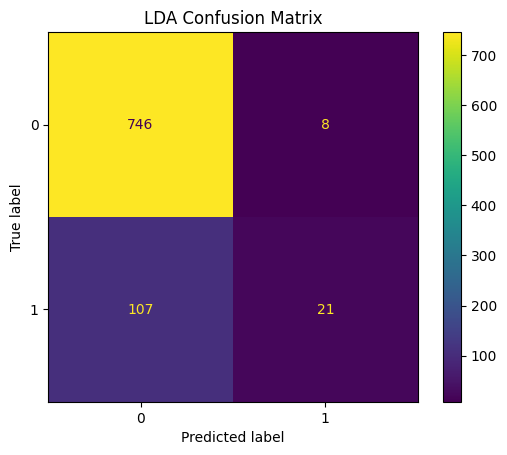

In [21]:
# Create the confusion matrix for teseting data
confusion_matrix_lda = metrics.confusion_matrix(y_test, lda_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lda)
cm_display.plot()

# Show the confusion matrix
plt.title("LDA Confusion Matrix")
plt.show()

In [22]:
# Classifiation report for LDA
print("Classification Report for LDA Test")
print(classification_report(y_test, lda_test))

Classification Report for LDA Test
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       754
           1       0.72      0.16      0.27       128

    accuracy                           0.87       882
   macro avg       0.80      0.58      0.60       882
weighted avg       0.85      0.87      0.83       882



#### Retrain models with adjsuted parameters

In [23]:
## Getting rid of features w/ high multi-collinearity and low importance in both DT and RF
cols_drop = ['log_YearsAtCompany', 'log_TotalWorkingYears', 'JobRole_Sales Representative', 'PerformanceRating', 'JobRole_Manager', 'Department_Research & Development']
model_df_small = model_df.drop(cols_drop, axis = 1)

In [24]:
# Assign the independent and dependent variables
y_s = model_df_small['Attrition_Yes']
X_s = model_df_small.drop(columns = ['Attrition_Yes'])

# partitioning data into 90% train and 10% test, and then will further split for validation
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = .2, random_state = 12345)

In [25]:
# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt_s, y_train_smt_s = smote.fit_resample(X_train_s, y_train_s) # X_smt and y_smt will be used in modeling if concerns around balanced data

y_train_smt_s.value_counts()

0    2668
1    2668
Name: Attrition_Yes, dtype: int64

In [26]:
# Adjusted variables with LDA model
lda_mod_s = LinearDiscriminantAnalysis()

lda_mod_grd_s = {'solver': ['svd', 'lsqr', 'eigen'],
                  'shrinkage': [.001, .01, .05, .1, .5, 1, 'auto', None],
                  'store_covariance': [True, False]}

lda_mod_fit_s = skl_class_model(train_x = X_train_smt_s,
                                 train_y = y_train_smt_s,
                                 val_x=X_test_s,
                                 val_y=y_test_s, 
                                 skl_model=lda_mod_s,
                                 grid=lda_mod_grd_s,
                                 cv=5)

+++++++++++++++++++++++++++++++++++++++++++++++++
Best CV grid parameters for LinearDiscriminantAnalysis(): {'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True}
Training set
Confusion Matrix (Accuracy 0.7151)

       Prediction
Actual    0    1
     0 1908  760
     1  760 1908

Additional Eval Measures for LinearDiscriminantAnalysis():
Recall = 0.7151424287856072
Precision = 0.7151424287856072
F1 = 0.7151424287856072

_________________________________________________
Val/Test set
Confusion Matrix (Accuracy 0.6780)

       Prediction
Actual   0   1
     0 258 116
     1  26  41

Additional Eval Measures for LinearDiscriminantAnalysis():
Recall = 0.6119402985074627
Precision = 0.2611464968152866
F1 = 0.3660714285714286

Start Time = 2023-04-01 16:36:17.202311
End Time = 2023-04-01 16:36:28.038524
Script Time = 0:00:10.836213
